[View in Colaboratory](https://colab.research.google.com/github/shubhamSonarghare/Machine-learnig/blob/master/Path%20Follower/main.ipynb)

In [1]:
import tensorflow as tf;
from tensorflow.examples.tutorials.mnist import input_data;

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print (mnist.test.images.shape)
n_classes = 5
batch_size = 5

x = tf.placeholder('float', name = "MyInput")
y = tf.placeholder('float')

#keep_rate = 0.8
#keep_prob = tf.placeholder(tf.float32)

def conv2d(x, W):
	return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def maxpool2d(x):
	return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


def convolutional_neural_network(x):
	weights = {'W_conv1': tf.Variable(tf.random_normal([5,5,3,32])),
				'W_conv2': tf.Variable(tf.random_normal([5,5,32,64])),
				'W_fc': tf.Variable(tf.random_normal([50*100*64, 1024])),
				'out': tf.Variable(tf.random_normal([1024, n_classes]))}

	biases = {'b_conv1': tf.Variable(tf.random_normal([32])),
				'b_conv2': tf.Variable(tf.random_normal([64])),
				'b_fc': tf.Variable(tf.random_normal([1024])),
				'out': tf.Variable(tf.random_normal([n_classes]))}

	x= tf.reshape(x, shape=[-1, 200, 400,3])
	conv1 = conv2d(x, weights['W_conv1'])
	conv1 = maxpool2d(conv1)

	conv2= conv2d(conv1, weights['W_conv2'])
	conv2 = maxpool2d(conv2)

	fc= tf.reshape(conv2, [-1,50*100*64])
	fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])

	#fc = tf.nn.dropout(fc, keep_rate)

	output = tf.matmul(fc, weights['out'])+biases['out']
	#output = tf.identity(output, name="MyOutput")
	return output
  


def train_neural_network(x):
	prediction = convolutional_neural_network(x)

	#y_clipped = tf.clip_by_value(prediction, 1e-10, 0.9999999)
	#cost = tf.reduce_mean(tf.reduce_sum(y*tf.log(y_clipped) + (1-y) * tf.log(1-y_clipped), axis = 1))
	cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))

	optimizer = tf.train.AdamOptimizer().minimize(cost)
	#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)
	# cycles for feed forward and backprop
	hm_epoch = 10

	with tf.Session() as sess:
		sess.run(tf.global_variables_initializer())
		total_batch = int(mnist.train.num_examples/batch_size)
		for epoch in range(hm_epoch):
			epoch_loss = 0
			for _ in range(total_batch):
				epoch_x, epoch_y = mnist.train.next_batch(batch_size)
				_, c = sess.run([optimizer , cost], feed_dict = {x: epoch_x , y:epoch_y})
				epoch_loss += c
			print ('Epoch ', epoch, 'completed out of ', hm_epoch, 'Loss: ', epoch_loss)

		correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
		accuracy = tf.reduce_mean(tf.cast(correct,'float'))
		print ('Accuracy:: ', accuracy.eval({x:mnist.test.images , y:mnist.test.labels}) )


#train_neural_network(x)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(10000, 784)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import matplotlib
from tensorflow.python.saved_model import tag_constants
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
#!mkdir New_model

In [0]:
class Generate_from_TFRecord():
	def __init__(self, tfrecord_file):
		self.tfrecord = tfrecord_file

	def extract_image_data(self,batch_size, shuffle):
		def _extract_fn(tfrecord):
			features={
				'image/height': tf.FixedLenFeature([], tf.int64),
				'image/width': tf.FixedLenFeature([], tf.int64),
				'image/image_raw': tf.FixedLenFeature([], tf.string),
				'image/class/label': tf.FixedLenFeature([], tf.int64),
				'image/class/text': tf.FixedLenFeature([], tf.string)}

			sample = tf.parse_single_example(tfrecord, features)

			#image = tf.decode_raw(sample['image/image_raw'],tf.uint8)
			image = tf.image.decode_jpeg(sample['image/image_raw'])
			height = tf.cast(sample['image/height'], tf.int32)
			width = tf.cast(sample['image/width'], tf.int32)
			image = tf.reshape(image,[1,height*width*3])
			#image = tf.reshape(image, [height, width, 3])
			label = tf.cast(sample['image/class/label'], tf.int32)
			label_txt = tf.cast(sample['image/class/text'], tf.string)
			
			return [image, label_txt, label, height, width]

		tfrecord_file = self.tfrecord
		dataset = tf.data.TFRecordDataset([tfrecord_file])
		dataset = dataset.map(_extract_fn)

		if batch_size != None:
			print("Preparing batches.....")
			dataset = dataset.batch(batch_size)
		#dataset = dataset.repeat(10)
		if shuffle == True:
			print("Shuffling.....")
			dataset= dataset.shuffle(buffer_size = len(tfrecord_file))
		return dataset

	def generate_data(self, batch_size = None, shuffle = False):
		print("TFRecord file used: ", self.tfrecord)
		dataset = self.extract_image_data(batch_size, shuffle)
		iterator = dataset.make_one_shot_iterator()
		next_batch = iterator.get_next()
		return next_batch
		

	def get_num_examples(self):
		cnt=0
		imge, text, lab, ht, wdth = self.generate_data()
		with tf.Session() as sess:
			sess.run(tf.initializers.global_variables())
			try:
				while(1):
					img_dat, txt, labl, hgth, wth = sess.run([imge, text, lab, ht, wdth])
					cnt+=1
			except:
				pass
		return cnt


In [4]:
dat = Generate_from_TFRecord('drive/My Drive/Dataset/path_foll_compr_reshaped_train.tfrecord')
print('NUMS:: ', dat.get_num_examples())

TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_train.tfrecord
NUMS::  851


In [5]:
def train_CNN_for_pathFollowing(tfrecordFile,valida_tfrecordFile, batch_size):
  train_data = Generate_from_TFRecord(tfrecordFile)
  train_nums = train_data.get_num_examples()
  
  #train_image, _, train_label,_, _ = train_data.generate_data(batch_size= batch_size)
  #valid_data = Generate_from_TFRecord(valida_tfrecordFile)
  #valid_nums = valid_data.get_num_examples()
  #valid_image, _, valid_label,_, _ = valid_data.generate_data()
  
  print ("Using ", tfrecordFile, "for training and ", valida_tfrecordFile,"for validation")
  
  prediction = convolutional_neural_network(x)
  prediction = tf.identity(prediction, name="myOutput")
	#y_clipped = tf.clip_by_value(prediction, 1e-10, 0.9999999)
	#cost = tf.reduce_mean(tf.reduce_sum(y*tf.log(y_clipped) + (1-y) * tf.log(1-y_clipped), axis = 1))
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
  optimizer = tf.train.AdamOptimizer().minimize(cost)
	#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)
	# cycles for feed forward and backprop
  hm_epoch = 5
  save_path = "/content/model_final.ckpt"
  #saver = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(train_nums/batch_size)
    valid_data = Generate_from_TFRecord(valida_tfrecordFile)
    valid_nums = valid_data.get_num_examples()
    valid_image, _, valid_label,_, _ = valid_data.generate_data()
    
    for epoch in range(hm_epoch):
      epoch_loss = 0
      train_data = Generate_from_TFRecord(tfrecordFile)
      train_nums = train_data.get_num_examples()
      train_image, _, train_label,_, _ = train_data.generate_data(batch_size= batch_size)
      
      for _ in range(total_batch):
        epoch_x, epoch_y = sess.run([train_image, train_label])
        #print("Shape:>>>>", epoch_x.shape)
        epoch_y = sess.run(tf.one_hot(epoch_y, depth=5))
        _, c = sess.run([optimizer , cost], feed_dict = {x: epoch_x , y:epoch_y})
        epoch_loss += c
      print ('Epoch ', epoch, 'completed out of ', hm_epoch, 'Loss: ', epoch_loss)
    
    correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct,'float'))
    inputs={"myInput": x}
    outputs={"myOutput": prediction}
    valid_x=np.array([])
    valid_y=np.array([])
    tf.saved_model.simple_save(sess, '/content/New_model/model', inputs, outputs)
    cnc=0
    try:
      while(1):
        cnc+=1
        Vx, Vy = sess.run([valid_image, valid_label])
        #print (Vx)
        #print ("Curr Valid x>>", valid_x)
        #Vx = Vx.flatten()
        #plt.figure()
        #z = Vx.reshape((200,400,3))
        #plt.imshow(Vx.reshape((200,300,3)))
        #plt.imshow(z)
        #plt.show()
        #Vx = Vx.flatten()
        #print("VX init shape>> ", Vx.shape)
        
        #print(">>",Vx.shape,Vy)
        
        #Vx = Vx.reshape((1,len(Vx)))
        Vy = sess.run(tf.one_hot(Vy, depth=5))
        Vy = sess.run(tf.reshape(Vy,[1,len(Vy)]))
        #Vy = Vy.reshape((1,len(Vy)))
        #print(">>",Vx.shape, Vy.shape,valid_x.size==0)
        if valid_x.size==0:
          #valid_x = np.append(valid_x,Vx)
          valid_x = Vx[:]
          #print("<<<>>>", valid_x)
          #valid_x = sess.run(tf.reshape(valid_x,[1,len(valid_x)]))
          valid_y = Vy[:]
          #valid_y = sess.run(tf.reshape(valid_y,[1,len(valid_y)]))
        else:
          #print("Stacking....")
          valid_x = np.append(valid_x,Vx,axis=0)
          valid_y = np.append(valid_y,Vy, axis=0)
          #valid_x = sess.run(tf.stack([valid_x,Vx]))
          #valid_y = sess.run(tf.stack([valid_y,Vy]))
        #print (type(Vx), type(Vy))
        #print (valid_x,"\n",valid_y)
        
    except:
      print ("Passing....>.", cnc)
      pass
    print(valid_x.shape)
    print(valid_y.shape)
    print ('Accuracy:: ', accuracy.eval({x:valid_x , y:valid_y}) )
    #saver.save(sess, save_path)
  
validation_tf = 'drive/My Drive/Dataset/path_foll_compr_reshaped_validation.tfrecord' 
training_tf = 'drive/My Drive/Dataset/path_foll_compr_reshaped_train.tfrecord'
train_CNN_for_pathFollowing(training_tf, validation_tf, batch_size)

TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_train.tfrecord
Using  drive/My Drive/Dataset/path_foll_compr_reshaped_train.tfrecord for training and  drive/My Drive/Dataset/path_foll_compr_reshaped_validation.tfrecord for validation
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_validation.tfrecord
TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_validation.tfrecord
TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_train.tfrecord
TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_train.tfrecord
Preparing batches.....
Epoch  0 completed out of  5 Loss:  19240338252.78125
TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_train.tfrecord
TFRecord file used:  drive/My Drive/Dataset/pat

In [0]:
#!rm -rf New_model/

In [7]:
#data = [[1,2,3],[4,5,6]]
data = [[1,2,3]]
data_np = np.asarray(data, np.float32)
print ("INIT > \n", data_np, "\n", data_np[0])
data_tf = tf.convert_to_tensor(data_np, np.float32)
data2_tf = tf.convert_to_tensor(data_np[0], np.float32)
with tf.Session() as sess:
  a = sess.run(data_tf)
  b = sess.run(tf.reshape(data2_tf,[1,3]))
  z= np.append(a,b,axis=0)
  print (z)
  #z = np.append(data_tf,data2.tf.reshape)
  #print (z)
  #print (sess.run(data2_tf))

#sess = tf.InteractiveSession()  
#print(data_tf.eval())

#sess.close()

INIT > 
 [[1. 2. 3.]] 
 [1. 2. 3.]
[[1. 2. 3.]
 [1. 2. 3.]]


# **Restoring from saved model.**

In [3]:
validation_tf_vis = 'drive/My Drive/Dataset/path_foll_compr_reshaped_validation.tfrecord'
valid_data = Generate_from_TFRecord(validation_tf_vis)
valid_image, _, valid_label,_, _ = valid_data.generate_data()
cn = 0
test_data = np.array([])
test_label = np.array([])
with tf.Session() as sess:
  try:
      while(1):
        cn+=1
        Vx, Vy = sess.run([valid_image, valid_label])
        Vy = sess.run(tf.one_hot(Vy, depth=5))
        Vy = sess.run(tf.reshape(Vy,[1,len(Vy)]))
        if test_data.size==0:
          test_data = Vx[:]
          test_label = Vy[:]
        else:
          test_data = np.append(test_data,Vx,axis=0)
          test_label = np.append(test_label,Vy, axis=0)
  except:
    print ("Passing..", cn)
    pass

TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_validation.tfrecord
Passing.. 47


In [16]:
'''
tf.reset_default_graph()
imported_meta = tf.train.import_meta_graph("model_final.ckpt.meta")
#x = tf.placeholder('float')
#y = tf.placeholder('float')
#prediction = convolutional_neural_network(x) 
with tf.Session() as sess:
  imported_meta.restore(sess,tf.get.latest_checkpoint('./'))
  #print(sess.run('valix_x')) 
  corr = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
  accu = tf.reduce_mean(tf.cast(correct,'float'))
  print ('Accuracy:: ', accu.eval({x:data.test , y:data_label, session=sess}) )
  #prediction=tf.argmax(y,1)
  #print (prediction.eval(feed_dict={x: test_data, },session=sess))

'''
'''
saver = tf.train.import_meta_graph("model_final.ckpt.meta")
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('output/BiasAdd:0')
print (x.type)
'''
#tf.saved_model.loader.load(sess, [tag_constants.SERVING],'/content/New_model/model/' )
gr=tf.Graph()
ip = tf.placeholder('float')
prediction = tf.placeholder('float')
save_path = '/content/model.ckpt'
#with graph.as_default():
with tf.Session() as sess:
  tf.saved_model.loader.load(sess, [tag_constants.SERVING],'/content/New_model/model/' )
  gr =  tf.get_default_graph()
  ip = gr.get_tensor_by_name('MyInput:0') 
  prediction = gr.get_tensor_by_name('myOutput:0')
  #print(sess.run(graph.is_feedable('myOutput:0')))
  print (sess.run(prediction, feed_dict={ip:test_data[6]}))
  #print (sess.run('myOutput:0', feed_dict={'MyInput:0':test_data}))


INFO:tensorflow:Restoring parameters from /content/New_model/model/variables/variables
[[-8.3583180e+06 -6.9242992e+07 -5.8009308e+07 -4.0400372e+07
   1.4052245e+08]]


In [5]:
predict = tf.contrib.predictor.from_saved_model('/content/New_model/model/')
x = tf.placeholder('float')
print (predict({"myInput":test_data[6]}))

INFO:tensorflow:Restoring parameters from /content/New_model/model/variables/variables
{'myOutput': array([[-8.3583180e+06, -6.9242992e+07, -5.8009308e+07, -4.0400372e+07,
         1.4052245e+08]], dtype=float32)}


In [42]:
op = predict({"myInput":test_data[43]})
print (np.argmax(op['myOutput']))
#print(predict({"myInput":test_data[6]}))
#with tf.Session() as sess:
#  print (sess.run(tf.argmax(predict({"myInput":test_data[6]}),1) ))

3


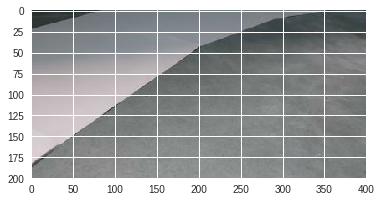

In [43]:
#print (test_data[0].shape)

imageToUse = test_data[43]
plt.figure()
plt.imshow(np.reshape(imageToUse,[200,400,3]), interpolation="nearest", cmap="gray", )
plt.show()